<a href="https://colab.research.google.com/github/bulutirm/solidWasteDetection/blob/main/solidWasteDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Solid Waste Detection**

In [1]:
pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

#Warningsleri kapatmak için kullanılmaktadır.
import warnings
warnings.filterwarnings('ignore')

#Model değerlendirme için kullanılacak olan kütüphaneler
from sklearn.metrics import confusion_matrix, classification_report

#Model için kullanılacak olan kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 23 10:15:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Veri Setinin Okunması

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir_path = '/content/drive/MyDrive/Garbage Classification'

In [6]:
#Target size and Label
target_size = (224, 224)

waste_labels = {'cardboard' : 0, 'glass' : 1, 'metal' : 2, 'paper' : 3, 'plastic' : 4, 'trash' : 5}

In [7]:
def load_datasets(path):
  """
  Görsellerin bulunduğu dizindeki görüntüyü okuyup etkietlerini oluşturur.
  
  Parametreler
  path: Görsellerin bulunduğu dizini ifade eder.
  
  return
  x: Görüntülere ait matris bilgilerini tutar.
  labels: Görüntünün ait olduğu sınıf bilgisini tutan liste
  """

  x = []
  labels = []

  #Gönderdiğimiz pathdeki görüntüleri listeleyip sıralamaktadır.
  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    #Belirtilen pathdeki görüntüler openCv kütüphanesi ile okunmaktadır.
    img = cv2.imread(image_path)

    #Okunan görüntüler başlangıçta belirlenen target_size'a göre yeniden ölçeklendirilir.
    img = cv2.resize(img, target_size)

    #Ölçeklendirilen görüntüler x listesine eklenir.
    x.append(img)

    #Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı labelı temsil etmektedir.
    label = image_path.split(os.path.sep)[-2]

    #Yakalanan labellerin sayısal değer karşılıklarının olduğu waste_labels sözlüğü içerisinden gönderilen key
    #değerine karşılık value değeri alınarak label oluşturulur.
    labels.append(waste_labels[label])

  #Veri seti random bir şekilde karıştırılır
  x, labels = shuffle(x, labels, random_state = 42)

  #Boyut ve Sınıf bilgisi raporlamaktadır.
  print(f"X boyutu: {np.array(x).shape}")
  print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

  return x, labels  

In [8]:
x, labels = load_datasets(dir_path)

X boyutu: (2527, 224, 224, 3)
Label sınıf sayısı: 6 Gözlem sayısı: 2527


In [9]:
#Görüntü boyutlarının tutulması
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


In [10]:
def visualize_img(image_batch, label_batch):
  """
  Veri seti içerisinden görüntü görselleştirir.
  
  Parametreler
  image_batch: Görüntülere ait matris bilgilerini tutar.
  label_batch: Görüntünün ait olduğu sınıf bilgisini tutan liste.
  """

  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n]==1][0].title())
    plt.axis('off')

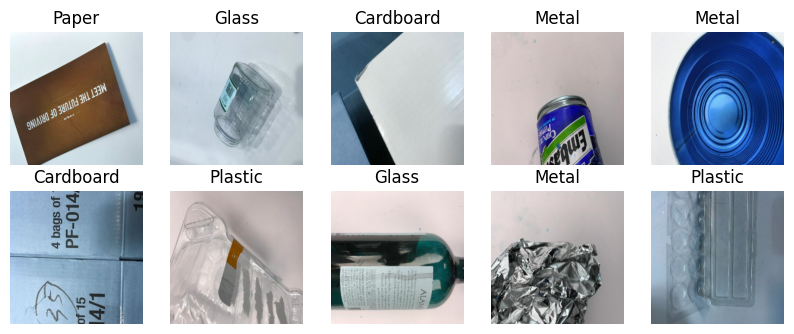

In [11]:
visualize_img(x, labels)



> # Veriyi Hazırlamak (Data Preparation)



In [12]:
#Train veri seti için bir generator tanımlıyoruz
train = ImageDataGenerator(horizontal_flip = True,
                           vertical_flip = True,
                           validation_split = 0.1,
                           rescale = 1./255,
                           shear_range = 0.1,
                           zoom_range = 0.1,
                           width_shift_range = 0.1,
                           height_shift_range = 0.1)

#Test veri seti için bir generator tanımlıyoruz.
test = ImageDataGenerator(rescale = 1/255,
                          validation_split = 0.1)

In [13]:
train_generator = train.flow_from_directory(directory = dir_path,
                                             target_size = (target_size),
                                             class_mode = 'categorical',
                                             subset = 'training')

test_generator = test.flow_from_directory(directory = dir_path,
                                          target_size = (target_size),
                                          batch_size = 251,
                                          class_mode = 'categorical',
                                          subset = 'validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


*italicized text*

> # Modelleme

4.1) Sıfırdan CNN Modeli Kurma
  * Sequential
  * Evrişim Katmanı (Convolution Layer, Conv2D)
  * Havuzlama Katmanı (Pooling Layer)
  * Aktivasyon Fonksiyonu Katmanı (Activation Layer)
  * Flattening Katmanı
  * Dense Katmanı
  * Dropout Katmanı





In [14]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                 input_shape = (input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation='softmax'))

4.2) Model Özeti

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

4.3) Optimizasyon ve Değerlendirme Metriklerin Ayarlanması

In [16]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

In [17]:
callbacks = [EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min'),
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)]

4.4) Modelin Eğitilmesi

In [19]:
history = model.fit_generator(generator=train_generator,
                              epochs=100,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              workers=4,
                              steps_per_epoch=2276//32,
                              validation_steps=251//32)

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 1.0819 - precision: 0.7475 - recall: 0.4051 - acc: 0.5784
Epoch 1: val_loss improved from 1.09768 to 1.09123, saving model to mymodel.h5
71/71 [==============================] - 32s 441ms/step - loss: 1.0819 - precision: 0.7475 - recall: 0.4051 - acc: 0.5784 - val_loss: 1.0912 - val_precision: 0.7639 - val_recall: 0.4382 - val_acc: 0.5976
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 1.0652 - precision: 0.7593 - recall: 0.4189 - acc: 0.6025
Epoch 2: val_loss did not improve from 1.09123
71/71 [==============================] - 26s 356ms/step - loss: 1.0652 - precision: 0.7593 - recall: 0.4189 - acc: 0.6025 - val_loss: 1.1470 - val_precision: 0.7155 - val_recall: 0.3307 - val_acc: 0.5618
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 1.0177 - precision: 0.7769 - recall: 0.4577 - acc: 0.6181
Epoch 3: val_loss did not improve from 1.09123
71/71 [==============================]

4.5) Accuracy ve Loss Grafikleri

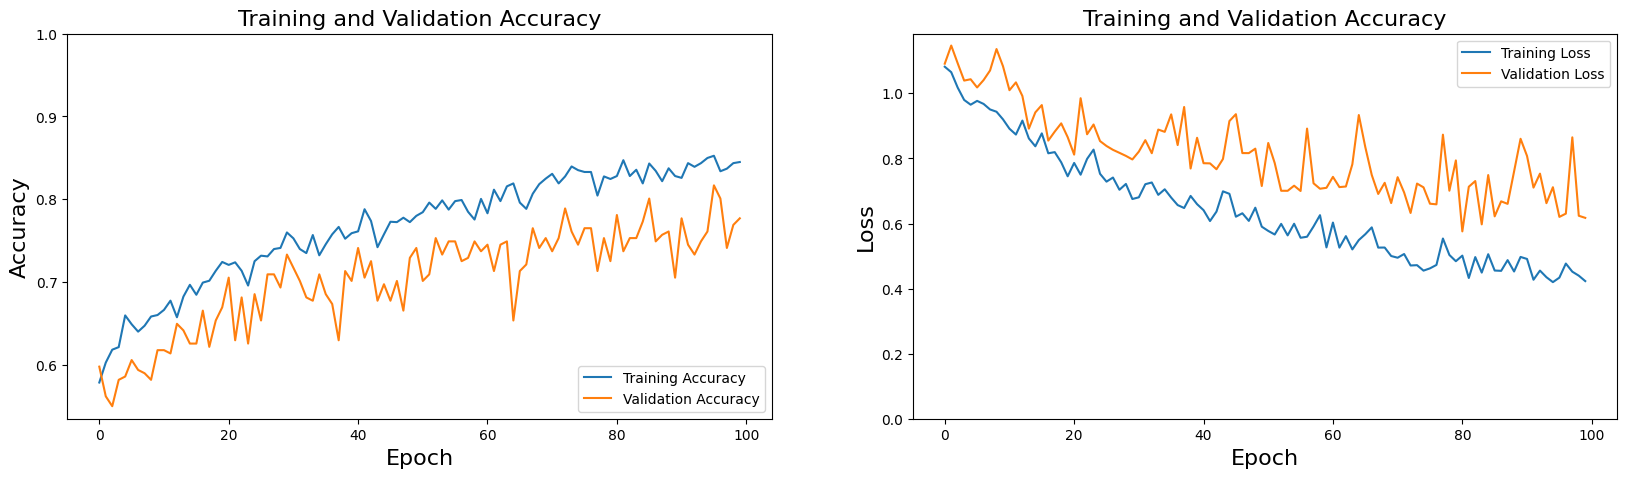

In [20]:
#Accuracy Grafiği

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=16)

#Loss grafiği
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Accuracy', fontsize=16)

plt.show()

> # Değerlendirme

In [21]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

1/1 [==============================] - 1s 1s/step - loss: 0.6174 - precision: 0.8619 - recall: 0.7211 - acc: 0.7769


In [22]:
print("\nTest accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.1f%%" % (100.0 * loss))
print("\nTest precision: %.1f%%" % (100.0 * precision))
print("\nTest recall: %.1f%%" % (100.0 * recall))


Test accuracy: 77.7%

Test loss: 61.7%

Test precision: 86.2%

Test recall: 72.1%


In [23]:
#Clasification Report
x_test, y_test = test_generator.next()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

8/8 [==============================] - 0s 24ms/step


In [24]:
y_pred

array([0, 3, 1, 1, 3, 4, 1, 3, 3, 1, 4, 3, 0, 2, 1, 2, 4, 3, 2, 4, 1, 3,
       4, 3, 1, 3, 4, 2, 1, 2, 3, 3, 0, 2, 5, 2, 4, 2, 3, 3, 3, 4, 3, 2,
       4, 0, 3, 0, 0, 3, 2, 5, 0, 4, 2, 0, 2, 0, 3, 3, 2, 4, 2, 4, 0, 1,
       2, 1, 3, 3, 1, 2, 2, 2, 1, 1, 4, 1, 4, 5, 3, 2, 2, 1, 3, 2, 0, 3,
       2, 5, 2, 4, 3, 4, 2, 0, 1, 1, 1, 0, 1, 0, 2, 3, 0, 3, 1, 3, 2, 3,
       1, 1, 3, 4, 1, 4, 2, 2, 2, 2, 2, 4, 2, 0, 4, 3, 0, 3, 2, 2, 3, 1,
       0, 0, 1, 5, 5, 2, 2, 4, 3, 5, 1, 1, 2, 0, 1, 0, 4, 2, 5, 2, 2, 0,
       3, 0, 3, 3, 3, 4, 3, 3, 4, 5, 2, 0, 5, 4, 2, 0, 4, 1, 1, 0, 2, 4,
       2, 2, 2, 2, 0, 3, 4, 1, 4, 2, 2, 3, 4, 1, 3, 0, 0, 1, 0, 2, 3, 1,
       0, 4, 4, 5, 5, 1, 0, 4, 1, 1, 2, 2, 4, 1, 3, 3, 4, 2, 3, 3, 0, 3,
       3, 0, 2, 1, 3, 3, 2, 3, 2, 1, 0, 3, 0, 3, 3, 3, 4, 3, 3, 5, 2, 1,
       1, 4, 3, 3, 0, 3, 1, 3, 2])

In [25]:
target_names = list(waste_labels.keys())

In [26]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.81      0.75      0.78        40
       glass       0.88      0.76      0.82        50
       metal       0.60      0.85      0.71        41
       paper       0.89      0.95      0.92        59
     plastic       0.73      0.56      0.64        48
       trash       0.69      0.69      0.69        13

    accuracy                           0.78       251
   macro avg       0.77      0.76      0.76       251
weighted avg       0.79      0.78      0.78       251



In [27]:
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
E: Package 'libfluidsynth1' has no installation candidate


In [30]:
#Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label', fontweight="bold")
  plt.xlabel('Predicted label', fontweight="bold")

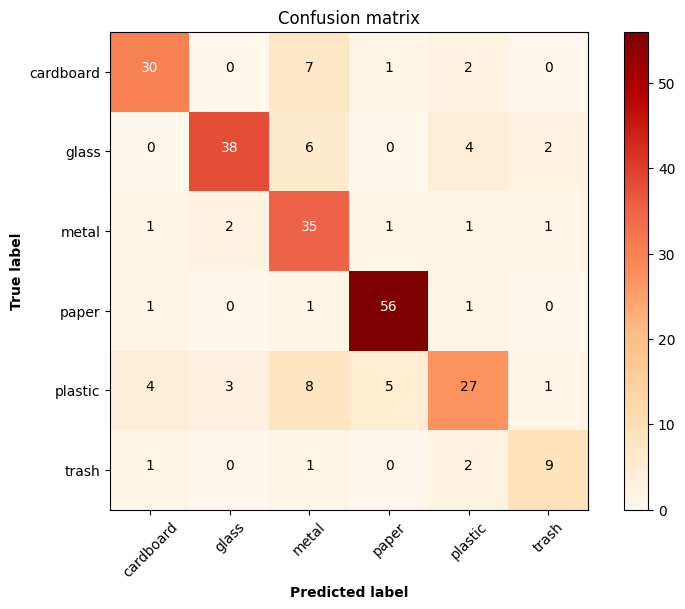

In [31]:
plot_confusion_matrix(cm, waste_labels.keys(),
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd)



> # Modelin Kullanılması / Test Edilmesi



In [32]:
waste_labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [33]:
def model_testing(path):
  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img) / 255.0
  p = model.predict(img.reshape(1, 224, 224, 3))
  predicted_class = np.argmax(p[0])

  return img, p, predicted_class

In [37]:
img1, p1, predicted_class1 = model_testing('/content/drive/MyDrive/Garbage Classification/metal/metal99.jpg')

1/1 [==============================] - 0s 27ms/step
